In [13]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from laser_jitter.data import TimeSeries
from laser_jitter.production import (get_datasets, get_default_model_params,
                                     get_model, train_model)

## Prepare dataset from array of observations

In [2]:
# Load data
data = pd.read_csv("../data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])
print(f"Time series: {ts_data.shape}")

Time series: (20000,)


In [3]:
ts_data_2 = np.vstack([ts_data, ts_data]).T
print(ts_data_2.shape)

(20000, 2)


In [4]:
# introduce smoothing parameters for the series
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

n_lookback = 300
n_forecast = 100

# define parameters for series pre-processing
series_params = {
    "smooth_params": smooth_params,
    "scaling": "standard",
    "train_size": 0.8,
}

# define parameters for dataset_creation
dataset_params = {
    # sequence parameters for prediction
    "sequence_params": {
        "training_window": n_lookback,
        "prediction_window": n_forecast,
        "step": 1,
    },
    # dataloader params for training
    "dataloader_params": {
        "batch_size": 128,
        "drop_last": False,
    },
}


series_class, trainloader, testloader = get_datasets(ts_data, series_params,
                                                     dataset_params)

In [5]:
# create model
save_folder = "../models/rnn_test/"
model_params = get_default_model_params(n_features=1, n_lookback=n_lookback,
                                        n_forecast=n_forecast)
model = get_model(model_params, save_folder)

0 - train: 0.24146745891356078, valid: 0.2250522138743565
1 - train: 0.2185420888613482, valid: 0.21080103413812046
2 - train: 0.2050293486137859, valid: 0.197400008553061
3 - train: 0.19445583322009102, valid: 0.19216759451504412
4 - train: 0.18765589741409802, valid: 0.18555531907698203
5 - train: 0.18007788025453442, valid: 0.18322471375095434
6 - train: 0.17155643369330734, valid: 0.17467991827890791
7 - train: 0.1605319837566282, valid: 0.16736553891979414
8 - train: 0.14917906898944105, valid: 0.16193964769100322
9 - train: 0.13894681290524905, valid: 0.1567549474280456
10 - train: 0.13051341345808545, valid: 0.15450157276515303
11 - train: 0.12221353098017271, valid: 0.15397161656412586
12 - train: 0.1142664092486022, valid: 0.15563623555775347
13 - train: 0.1071718194689907, valid: 0.15454600237566848
14 - train: 0.09995016718252761, valid: 0.15535858813030967
15 - train: 0.09236120792930244, valid: 0.16103663346890745
16 - train: 0.08539720160550758, valid: 0.16219622282118634

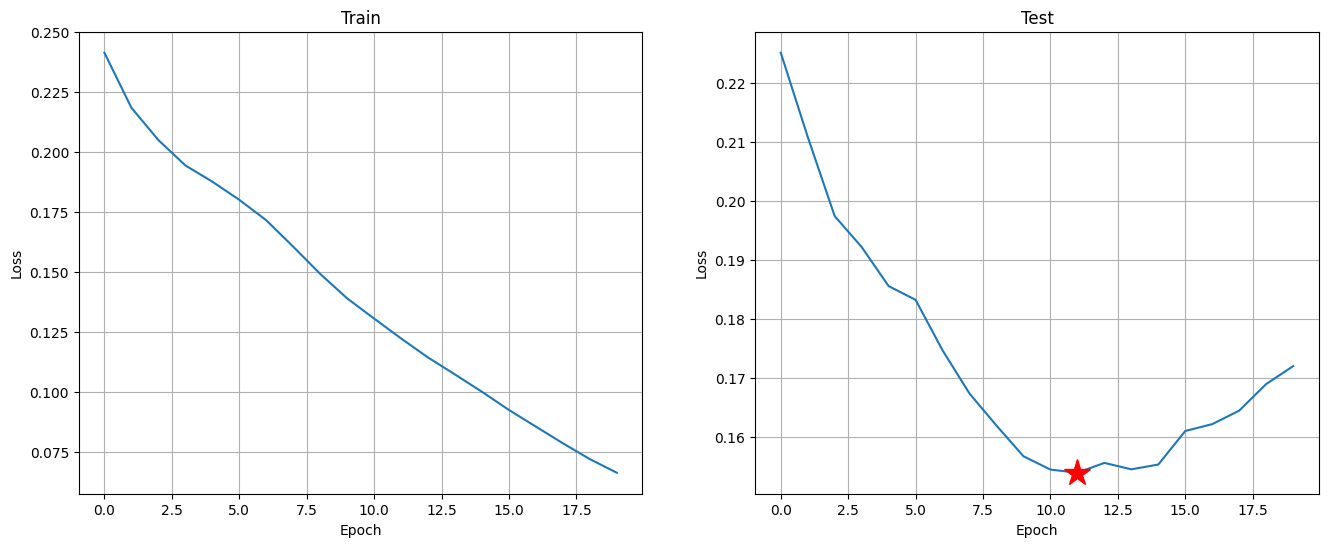

Model is trained. Saving the best model to ../models/rnn_test/.


In [7]:
# train model
train_model(model, trainloader, testloader, save_folder, n_epochs=20,
            verbose=True)

In [28]:
# predict on single time series
n_test = int(len(ts_data)*0.8)
ts_test = ts_data[n_test:]
print(f"Test length: {len(ts_test)}")

N = 5
idx = 2000
t0 = idx - N//2
t1 = idx #+ N//2
ts_past = ts_test[t0:t1+n_lookback]
ts_future = ts_test[t1+n_lookback:t1+n_lookback+n_forecast]
print(ts_past.shape, ts_future.shape)

t0 = time.perf_counter()
ts_predict = model.predict_on_series(ts_past, series_class, device='cuda')
t = time.perf_counter() - t0
print(f"Prediction time: {t*1000:.2f} ms")

Test length: 4000
(302,) (100,)
Prediction time: 8.78 ms


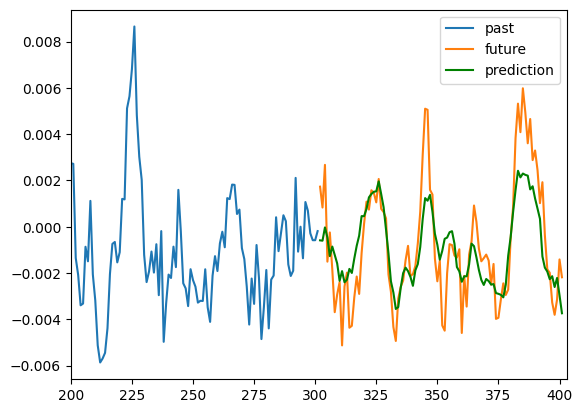

In [34]:
plt.figure()
plt.plot(np.arange(n_lookback+N//2), ts_past, color='tab:blue', label='past')
plt.plot(np.arange(n_lookback+N//2,n_lookback+N//2+n_forecast), ts_future,
         color='tab:orange', label='future')
plt.plot(np.arange(n_lookback+N//2,n_lookback+N//2+n_forecast), ts_predict,
         color='green', label='prediction')
plt.legend()
plt.xlim([200,403])
plt.show()